In [1]:
using MAT, Statistics, LinearAlgebra,Random, Plots, NonlinearSolve
using StaticArrays, Distributed, SciMLNLSolve, LineSearches

include("mvnrnd.jl")

mvnrnd (generic function with 1 method)

In [2]:
function loadInData()
    file = matopen("simulationData.mat")

    data = read(file, "data")

    close(file)

    return data
end

loadInData (generic function with 1 method)

In [3]:
data = loadInData()

grossy = reshape(data[:, 3], 46, 88)'
capital = reshape(data[:, 4], 46, 88)'; #NOMINAL CAPITAL
labor = reshape(data[:, 5], 46, 88)'; #NOMINAL LABOR
vadd = labor + capital; #NOMINAL VALUE;

removableSectors = [60, 80:88...];
grossy = grossy[setdiff(1:end, removableSectors), :];
capital = capital[setdiff(1:end, removableSectors), :];
labor = labor[setdiff(1:end, removableSectors), :];
vadd = vadd[setdiff(1:end, removableSectors), :];

grossSales = vec((sum(grossy, dims=2) .!= 0));
grossy = grossy[grossSales, :];
capital = capital[grossSales, :];
labor = labor[grossSales, :];
vadd = vadd[grossSales, :];


In [4]:
function getVariables(year)
    IO = data[data[:, 1].==year, :]
    temp = [8, 60, 62, 80:88...]
    IO = IO[setdiff(1:end, temp), setdiff(1:end, [1, 2, 3, 4, 5, 94])]
    IO = IO[:, setdiff(1:end, temp)]
    Ω = IO ./ sum(IO, dims=2)
    α = vadd[:, year-1959] ./ grossy[:, year-1959]
    β = ((I - diagm(1 .- α) * Ω)' * grossy[:, year-1959])
    @views β[β.<0] .= 0
    β = β / sum(β)
    λ = (inv(I - diagm(1 .- α) * Ω)' * β)
    L = λ .* α

    return α, β, Ω, L, λ

end

getVariables (generic function with 1 method)

In [5]:
ε = .5;
θ = 0.001;
σ = .9;

In [6]:
function problem(X :: AbstractVector{T}, A, β, Ω, α, ε, θ, σ,L) where T



    N = length(α)
    p = X[1:N]
    y = X[N+1:end]
    
    Out :: Vector{T} = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    Out[1:N] = p - (A .^ (ε - 1) .* (α .* w .^ (1- ε) + (1 .- α) .* q .^ (1 - ε))) .^ (1/(1-ε))
    Out[N+1:end] = y' - y' * diagm(p)^ε * diagm(A)^(ε-1) * diagm(q)^(θ-ε) * diagm(1 .- α) * Ω * diagm(p)^(-θ) - β'*diagm(p)^(-σ)*C
    
    return Out
end

problem (generic function with 1 method)

In [7]:
function problemJacobian(X, A, β, Ω, α, ε, θ, σ,L)
    N = length(α)
    p = @view X[1:N]
    y = @view X[N+1:end]
    
    Out = zeros(eltype(X),2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L
  
    
    DQDP = (q .^ θ * (p.^(-θ))') .* Ω;
    DWDP = diagm(A.^((ε-1)/ε) .* α.^(1/ε) .* y.^(1/ε) .* (1 ./ L).^(1/ε));
    DWDY = (1/ε) * diagm(p .* A.^((ε-1)/ε) .* α.^(1/ε).* (y.^(1/ε-1)) .* L.^(-1/ε));
    DCDP = DWDP' * L; 
    DCDY = DWDY' * L;

    DOut1DP = I - diagm(diagm(A)^(-1) * ((α .* (w .^ (1-ε)) + (1 .- α) .* (q.^(1-ε)))).^(ε/(1-ε))) * (diagm(α) * diagm(w.^(-ε))* DWDP + diagm(1 .-α)*diagm(q.^(-ε))*DQDP);

    DOut1DY =  -diagm(diagm(A.^(-1))*((α.*(w.^(1-ε))+(1 .- α).*(q.^(1-ε)))).^(ε/(1-ε)))*(diagm(α)*diagm(w.^(-ε))*DWDY);

    DOut2DP = -(ε * diagm(p.^(-θ))*Ω'*diagm((p.^(ε-1)).*(y).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))
        + (θ-ε)*diagm(p.^(-θ))*Ω'*diagm((p.^(ε)).*(y).*(q.^(θ-ε-1)).*(1 .- α).*(A.^(ε-1)))*DQDP 
        - σ*diagm(β.*p.^(-σ-1))*C + broadcast(*, β.*(p.^(-σ)), DCDP')
        - θ* diagm(p.^(-θ-1)).*diagm(Ω'*diagm((p.^(ε)).*(q.^(θ-ε)).*(1 .- α).*(A.^(ε-1)))*y));

    DOut2DY = I - (diagm(p)^ε*diagm(A)^(ε-1)*diagm(q)^(θ-ε)*diagm(1 .- α)*Ω*diagm(p)^(-θ))' - broadcast(*, β.*(p.^(-σ)), DCDY');
    OutDeriv = [DOut1DP DOut1DY; DOut2DP DOut2DY];

end

problemJacobian (generic function with 1 method)

In [8]:
trials = 50;
GDP = zeros(trials)
λ = zeros(76,trials)

function f!(F,u,p)
    F[1:152] = problem(u,p,beta,Omega,alpha,ε,θ,σ,L)
end

function j!(J,u,p)
    J[1:152,1:152] = problemJacobian(u,p,beta,Omega,alpha,ε,θ,σ,L)
end

f = NonlinearFunction(f!)

Threads.@threads for k in 1:trials
    
        
    A = exp.(mvnrnd(-1/2*diag(Sigma),diagm(diag(Sigma))));
    
    init = [Complex.(exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A)))..., Complex.(domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A)))...];
    
    #init = [exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A))..., (domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A)))...]


    p = A

    ProbN = NonlinearProblem(f,init,p)
    sol = solve(ProbN,NLSolveJL(linesearch = HagerZhang(),method = :newton), reltol = 1e-8,abstol = 1e-8)

    x = sol.u
    println("solv")

    GDP[k] = (x[1:76] .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(x[77:152].^(1/ε)).* L .^ (-1/ε))' * L;
    λ[:,k] = (x[1:76] .* x[77:end]) / GDP[k] 


        
end

TaskFailedException: TaskFailedException

    nested task error: UndefVarError: Sigma not defined
    Stacktrace:
     [1] macro expansion
       @ ~/Schreibtisch/BeyondHulten/Translation/OtherSolver.ipynb:18 [inlined]
     [2] (::var"#67#threadsfor_fun#10"{var"#67#threadsfor_fun#9#11"{UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ Main ./threadingconstructs.jl:84
     [3] #67#threadsfor_fun
       @ ./threadingconstructs.jl:51 [inlined]
     [4] (::Base.Threads.var"#1#2"{var"#67#threadsfor_fun#10"{var"#67#threadsfor_fun#9#11"{UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:30

In [8]:
function shockSectorProgressively(sector, shocks, year=1983)

    (α, β, Ω, L, λ) = getVariables(year)

    x0 = Complex.([ones(76)..., λ...])
    f = NonlinearFunction((u, p) -> problem(u, p...), jac=(u, p) -> problemJacobian(u, p...))
    GDP = []
    for shock in shocks
        A = ones(76)
        A[sector] = shock




        p = [A, β, Ω, α, ε, θ, σ, L]
        ProbN = NonlinearProblem(f, x0, p)

        #sol = solve(ProbN,NewtonRaphson(), reltol = 1e-10,abstol = 1e-8)
        sol = solve(ProbN, NLSolveJL(method=:newton, linesearch=BackTracking()), reltol=1e-10, abstol=1e-8)

        x = sol.u

        p = real.(x[1:76])
        y = real.(x[77:152])
        append!(GDP, (p .* (A .^ ((ε - 1) / ε)) .* (α .^ (1 / ε)) .* (y .^ (1 / ε)) .* L .^ (-1 / ε))' * L)

        x0 = x
    end

    return GDP

end

shockSectorProgressively (generic function with 2 methods)

In [9]:
years = 1980:2000
M = 50

a = 0.7;
b = 1.3;



sectors = 1:60

GDP = zeros(2 * M, length(sectors), length(years))

@distributed for year in years
    for i in 1:length(sectors)
        GDP[1:M, i, year-(years[1]-1)] = shockSectorProgressively(sectors[i], LinRange(1, a, M), year)
        GDP[M+1:end, i, year-(years[1]-1)] = shockSectorProgressively(sectors[i], LinRange(1, b, M), year)
    end
end




In [38]:

@views reverse!(GDP[1:M, :,:], dims=1)
GDP = GDP[setdiff(1:end, M), :,:]

199×60×21 Array{Float64, 3}:
[:, :, 1] =
 0.960047  0.995523  0.996884  0.986077  …  0.985263  0.951592  0.994301
 0.960699  0.995637  0.996961  0.986463     0.985481  0.952323  0.994379
 0.961343  0.995749  0.997036  0.986841     0.985697  0.953047  0.994457
 0.961979  0.995859  0.997109  0.987212     0.985911  0.953763  0.994533
 0.962608  0.995966  0.99718   0.987574     0.986123  0.954472  0.994609
 0.963228  0.99607   0.99725   0.987929  …  0.986333  0.955174  0.994685
 0.963842  0.996172  0.997317  0.988276     0.98654   0.955869  0.99476
 0.964447  0.996272  0.997383  0.988617     0.986746  0.956556  0.994834
 0.965046  0.996369  0.997447  0.988949     0.986949  0.957237  0.994908
 0.965638  0.996464  0.997509  0.989275     0.987151  0.957911  0.994981
 ⋮                                       ⋱                      
 1.01677   1.00065   1.00069   1.00051   …  1.0077    1.02393   1.00327
 1.01691   1.00065   1.00069   1.00052      1.00777   1.02414   1.0033
 1.01705   1.00066   1

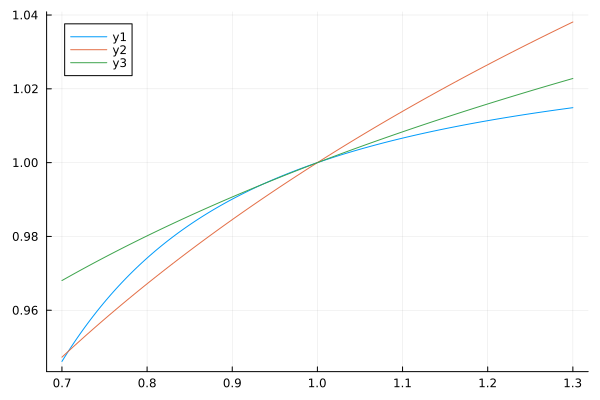

In [36]:
plot(LinRange(a,b,2*M-1),GDP[:,1,4])
plot!(LinRange(a,b,2*M-1),GDP[:,2,4])
plot!(LinRange(a,b,2*M-1),GDP[:,3,4])

In [15]:
GDP

19×3 Matrix{Float64}:
 3.3907    4.9875   1.01261
 0.99162   2.71701  1.01394
 0.992212  1.00974  1.01198
 0.993508  1.00788  1.01086
 0.9967    1.00619  1.00971
 1.00181   1.00928  1.00905
 1.00388   1.00965  1.0093
 1.00875   1.01141  1.00807
 1.00992   1.01204  1.01142
 1.00961   1.00961  1.00961
 1.0092    1.00792  1.00835
 1.0098    1.0086   1.00747
 1.00924   1.00683  1.00664
 1.00981   1.0063   1.00497
 1.00934   1.00562  1.00439
 1.00891   1.00501  1.00291
 1.00876   1.00459  1.0015
 1.00839   1.00286  1.00017
 1.00826   1.00359  0.999687

In [48]:
using GLMakie


fig = Figure()

sl_x = Slider(fig[1, 1], range = 1980:2000, startvalue = 1980)
sl_x2 = Slider(fig[2,1],range = 1:60, startvalue = 7)
ax = Axis(fig[3, 1])



indexYear = lift(sl_x.value) do x
    x - 1979 
end

indexSector = lift(sl_x2,value) do x
    x
end

lineShowing = @lift(GDP[:,$indexSector,$indexYear])

lines!(LinRange(a,b,2*M-1),lineShowing)

fig

ArgumentError: ArgumentError: invalid index: Observable(1) of type Observable{Int64}